In [ ]:
import pandas as pd

In [ ]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
df = pd.read_csv('municipality_bus_utilization.csv')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')


In [ ]:
df.head()

2017-08-05 to 2017-08-19) as assessment (test) data

In [ ]:
df["timestamp"].min()

In [ ]:
df["timestamp"].max()

In [ ]:
# Satış dağılımı nasıl?
df["usage"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])


In [ ]:

# Kaç belediye var?
df[["municipality_id"]].nunique()



In [ ]:
# Kaç otobüs var?
df[["total_capacity"]].sum()



In [ ]:
# Her belediyede eşit sayıda mı otobüs var?
df.groupby(["municipality_id"])["total_capacity"].sum()



In [ ]:
# Peki her store'da eşit sayıda mı sales var?
df.groupby(["municipality_id", "total_capacity"]).agg({"usage": ["sum"]})


In [ ]:
# mağaza-item kırılımında satış istatistikleri
df.groupby(["municipality_id", "total_capacity"]).agg({"usage": ["sum", "mean", "median", "std"]})

In [ ]:
check_df(df)

In [ ]:
df.isnull().sum()

In [ ]:
########################
# Date Features
########################


def create_date_features(df):
    df['month'] = df.timestamp.dt.month
    df['day_of_month'] = df.timestamp.dt.day
    df['day_of_year'] = df.timestamp.dt.dayofyear
    df['week_of_year'] = df.timestamp.dt.weekofyear
    df['day_of_week'] = df.timestamp.dt.dayofweek
    df['year'] = df.timestamp.dt.year
    df["is_wknd"] = df.timestamp.dt.weekday // 4
    df['is_month_start'] = df.timestamp.dt.is_month_start.astype(int)
    df['is_month_end'] = df.timestamp.dt.is_month_end.astype(int)
    return df





In [ ]:
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

In [ ]:
df = create_date_features(df)

In [ ]:
df.head()

In [ ]:
df.groupby(["municipality_id", "total_capacity", "month"]).agg({"usage": ["sum", "mean", "median", "std"]})

In [ ]:
########################
# Random Noise
########################

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))


In [ ]:
########################
# Lag/Shifted Features
########################


df.sort_values(by=['municipality_id', 'usage', 'timestamp'], axis=0, inplace=True)




In [ ]:
check_df(df)

In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["municipality_id", "total_capacity"])['usage'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


df = lag_features(df, [7, 14, 21, 28])



In [ ]:
########################
# Rolling Mean Features
########################

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["municipality_id", "total_capacity"])['usage']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


In [ ]:
df = roll_mean_features(df, [14,21])
df.tail()

In [ ]:
########################
# Exponentially Weighted Mean Features
########################

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["municipality_id", "total_capacity"])['usage'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [7, 14, 21, 28]



In [ ]:
df = ewm_features(df, alphas, lags)

In [ ]:
########################
# One-Hot Encoding
########################

df = pd.get_dummies(df, columns=['municipality_id', 'total_capacity', 'day_of_week', 'month'])

In [ ]:
########################
# Converting usage to log(1+sales)
########################

df['usage'] = np.log1p(df["usage"].values)



In [51]:
#####################################################
# Model
#####################################################

########################
# Custom Cost Function
########################

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [52]:
########################
# Time-Based Validation Sets
########################



,timestamp,usage,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_roll_mean_14,sales_roll_mean_21,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_21,sales_ewm_alpha_095_lag_28,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_21,sales_ewm_alpha_09_lag_28,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_21,sales_ewm_alpha_08_lag_28,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_21,sales_ewm_alpha_07_lag_28,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_21,sales_ewm_alpha_05_lag_28,municipality_id_0,municipality_id_1,municipality_id_2,municipality_id_3,municipality_id_4,municipality_id_5,municipality_id_6,municipality_id_7,municipality_id_8,municipality_id_9,total_capacity_397,total_capacity_587,total_capacity_697,total_capacity_1332,total_capacity_1930,total_capacity_2019,total_capacity_2813,total_capacity_2947,total_capacity_3113,total_capacity_3893,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_6,month_7,month_8
5370,2017-07-05 08:00:35,4.110874,5,186,27,2017,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
5550,2017-07-06 08:00:42,4.234107,6,187,27,2017,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
5381,2017-07-05 08:26:35,4.262680,5,186,27,2017,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
5561,2017-07-06 08:26:43,4.262680,6,187,27,2017,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2888,2017-06-22 07:59:45,4.382027,22,173,25,2017,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


In [57]:
test=df.loc[(df["timestamp"] >= "2017-08-05") & (df["timestamp"] < "2017-08-20"), :]

In [58]:
train= df.loc[(df["timestamp"] < "2017-08-05"), :]

In [59]:
val = df.loc[(df["timestamp"] >= "2017-07-29") & (df["timestamp"] < "2017-08-5"), :]


In [60]:
cols = [col for col in train.columns if col not in ['timestamp', 'usage', "municipality_id", "total_capacity"]]

In [61]:
Y_train = train['usage']
X_train = train[cols]

Y_val = val['usage']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((10390,), (10390, 63), (720,), (720, 63))

In [62]:
########################
# LightGBM Model
########################

# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [63]:
test.head()

,timestamp,usage,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_7,sales_lag_14,sales_lag_21,sales_lag_28,sales_roll_mean_14,sales_roll_mean_21,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_095_lag_21,sales_ewm_alpha_095_lag_28,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_21,sales_ewm_alpha_09_lag_28,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_14,sales_ewm_alpha_08_lag_21,sales_ewm_alpha_08_lag_28,sales_ewm_alpha_07_lag_7,sales_ewm_alpha_07_lag_14,sales_ewm_alpha_07_lag_21,sales_ewm_alpha_07_lag_28,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_14,sales_ewm_alpha_05_lag_21,sales_ewm_alpha_05_lag_28,municipality_id_0,municipality_id_1,municipality_id_2,municipality_id_3,municipality_id_4,municipality_id_5,municipality_id_6,municipality_id_7,municipality_id_8,municipality_id_9,total_capacity_397,total_capacity_587,total_capacity_697,total_capacity_1332,total_capacity_1930,total_capacity_2019,total_capacity_2813,total_capacity_2947,total_capacity_3113,total_capacity_3893,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_6,month_7,month_8
10398,2017-08-05 08:02:03,5.347108,5,217,31,2017,1,0,0,206.671009,200.356748,186.389602,182.301842,206.375780,201.978092,204.949618,197.997244,188.847375,181.899356,204.896880,197.987898,188.688989,181.794680,204.773759,197.942225,188.351610,181.554530,204.606006,197.845563,187.979674,181.235268,203.995060,197.367682,187.063257,180.096926,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
12358,2017-08-16 07:59:09,5.429346,16,228,33,2017,0,0,0,217.165760,209.519254,201.694566,198.098943,213.616379,210.596658,216.892493,207.949875,203.847250,196.897487,216.769879,207.898989,203.688000,196.789767,216.477693,207.791608,203.343982,196.555633,216.116239,207.669613,202.955625,196.284031,215.104003,207.312346,201.980240,195.470727,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
11659,2017-08-12 08:02:45,5.433722,12,224,32,2017,1,0,0,224.186052,211.232330,207.712284,197.170188,219.594642,218.993843,224.749862,211.944875,205.997374,197.999993,224.498777,211.878990,205.988969,197.999879,223.987964,211.711667,205.950950,197.997689,223.449642,211.490324,205.874541,197.986101,222.131500,210.832022,205.498765,197.841920,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
12176,2017-08-15 07:57:02,5.438079,15,227,33,2017,0,0,0,226.402633,215.286824,206.474593,198.259207,222.749024,216.155695,225.937493,211.997244,206.949869,199.900000,225.849878,211.987899,206.898897,199.799988,225.597593,211.942333,206.790190,199.599538,225.234892,211.847097,206.662362,199.395830,224.065750,211.416011,206.249383,198.920960,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
10936,2017-08-08 07:59:25,5.529429,8,220,32,2017,0,0,0,241.008221,228.807714,224.733321,214.278235,239.262287,235.778036,242.947218,227.999994,224.749862,211.944875,242.887468,227.999899,224.498777,211.878990,242.734899,227.998310,223.987964,211.711667,242.506531,227.990613,223.449642,211.490324,241.553841,227.891652,222.131500,210.832022,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


In [64]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003744 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0922317	training's SMAPE: 9.20054	valid_1's l1: 0.0992066	valid_1's SMAPE: 9.91155
[200]	training's l1: 0.0181552	training's SMAPE: 1.80517	valid_1's l1: 0.0176123	valid_1's SMAPE: 1.77155
[300]	training's l1: 0.0105557	training's SMAPE: 1.04975	valid_1's l1: 0.00791502	valid_1's SMAPE: 0.797452
[400]	training's l1: 0.00924188	training's SMAPE: 0.92139	valid_1's l1: 0.00707829	valid_1's SMAPE: 0.713272
[500]	training's l1: 0.00873029	training's SMAPE: 0.871863	valid_1's l1: 0.00676537	valid_1's SMAPE: 0.681822
[600]	training's l1: 0.00836209	training's SMAPE: 0.836016	valid_1's l1: 0.00658013	valid_1's SMAPE: 0.663191
[700]	training's l1: 0.00807944	training's SMAPE: 0.808527	valid_1's l1: 0.00635738	valid_1's SMAPE: 0.640836
[800]	training

In [65]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

0.6079407476172183

                       feature  split       gain
13   sales_ewm_alpha_095_lag_7    826  47.888733
7                  sales_lag_7   1902  28.662799
11          sales_roll_mean_14    703   7.976230
21    sales_ewm_alpha_08_lag_7    114   4.052611
17    sales_ewm_alpha_09_lag_7    139   3.351165
25    sales_ewm_alpha_07_lag_7     30   2.606012
29    sales_ewm_alpha_05_lag_7    111   1.931549
16  sales_ewm_alpha_095_lag_28    311   1.641906
8                 sales_lag_14    364   0.767560
10                sales_lag_28    275   0.199208
12          sales_roll_mean_21    235   0.170491
9                 sales_lag_21    736   0.164403
14  sales_ewm_alpha_095_lag_14    152   0.157466
15  sales_ewm_alpha_095_lag_21    209   0.088086
23   sales_ewm_alpha_08_lag_21     11   0.071269
26   sales_ewm_alpha_07_lag_14     14   0.041827
0                 day_of_month    752   0.030752
18   sales_ewm_alpha_09_lag_14     46   0.025162
34           municipality_id_1    167   0.023112
1                  d

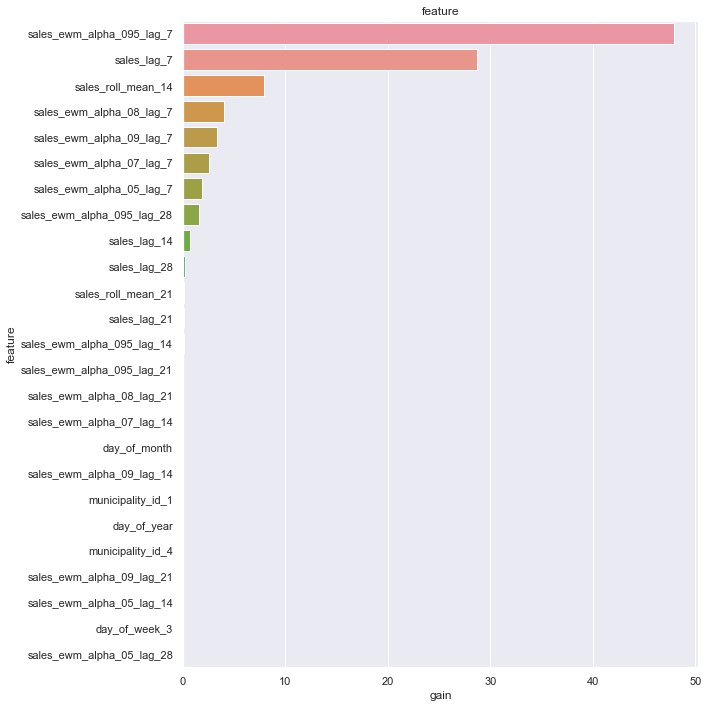

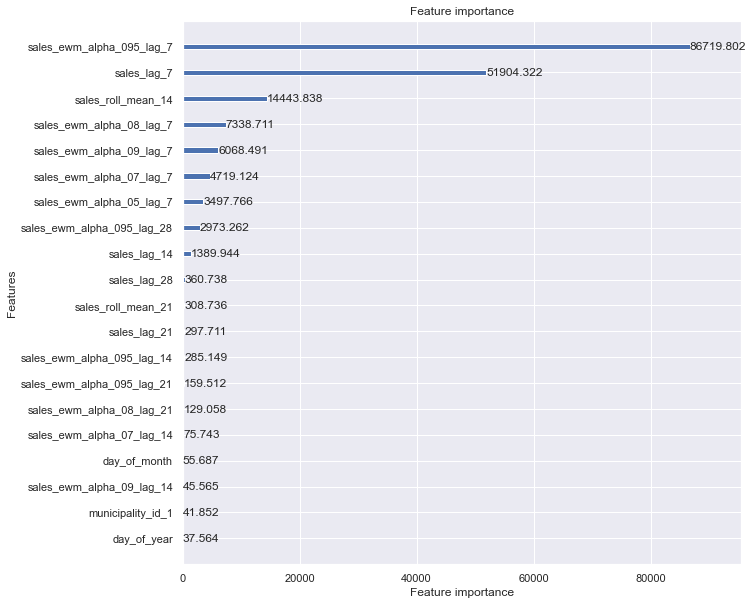

In [66]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)
plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()


In [67]:
train = df.loc[~df.usage.isna()]
Y_train = train['usage']
X_train = train[cols]


In [69]:
X_test = test[cols]

In [71]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = model.predict(X_test, num_iteration=model.best_iteration)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [72]:
submission_df = test.loc[:, ['municipality_id', 'usage']]
submission_df['usage'] = np.expm1(test_preds)
submission_df['municipality_id'] = submission_df.id.astype(int)
submission_df.head(20)

KeyError: "['municipality_id'] not in index"